In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

In [4]:
from hcdr_applications import load_datasets, preprocessing_transformations, make_prep_pipeline

In [5]:
def log_random(a, b, n):
    loga, logb = np.log(a), np.log(b)
    x = loga + (logb-loga)*np.random.random(n)
    y = np.exp(x)
    return y

def log_linear(a, b, n):
    loga, logb = np.log(a), np.log(b)
    x = np.linspace(loga, logb, n)
    return np.exp(x)
    
# sorted(np.round(log_random(0.01, 10, 10), 5)), sorted(np.round(log_linear(0.1, 10, 10), 5))

In [11]:
# load data
DATA_DIR = "../data"
# ds_names = ("application_train", "application_test", "bureau","bureau_balance","credit_card_balance","installments_payments",
#             "previous_application","POS_CASH_balance")
ds_names = ("application_train", "application_test")
datasets = load_datasets(DATA_DIR, ds_names)

In [12]:
y = datasets['application_train']['TARGET']
X = preprocessing_transformations(datasets['application_train'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
X_kaggle_test = datasets['application_test']

data_prep_pipeline, num_attribs_total, cat_attribs = make_prep_pipeline()

In [55]:
results = pd.DataFrame(columns=[
    "ExpID", 
    "Train Score", 
    "CV Score",
    "CV Score std",
    "Test Score", 
    "Train Time(s)", 
    "Test Time(s)"
])

In [87]:
%%time
full_pipeline_with_predictor = Pipeline([
    ("preparation", data_prep_pipeline),
    ("model", LogisticRegression(solver='saga', class_weight='balanced', random_state=0))
])
model = full_pipeline_with_predictor.fit(X_train, y_train)

CPU times: user 36.4 s, sys: 696 ms, total: 37.1 s
Wall time: 37.3 s


In [ ]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
distributions = {
    'model__C': loguniform(0.1, 10),
    'model__penalty':['l2', 'l1']
}
clf = RandomizedSearchCV(full_pipeline_with_predictor, 
                         distributions, 
                         random_state=0, cv=3, n_jobs=4, verbose=3, scoring='roc_auc')
_ = clf.fit(X_train, y_train)

In [92]:
clf.best_score_, clf.best_params_

(0.7476238439141207, {'model__C': 0.12984521643751776, 'model__penalty': 'l2'})

In [ ]:
clf.cv_results_

In [100]:
np.logspace(-4,-1,12)

array([0.0001    , 0.00018738, 0.00035112, 0.00065793, 0.00123285,
       0.00231013, 0.00432876, 0.00811131, 0.01519911, 0.02848036,
       0.05336699, 0.1       ])

In [ ]:
def conductGridSearch(models, params_grid, prep_pipeline, scoring,
                      X_train, y_train, X_test, y_test, 
                      results, prefix='', i=0, n_jobs=4, verbose=1):
    # scoring: passed to grid search
    i = 0
    for (name, model) in models:
        i += 1
        # Print model and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid.get(name, {})
        print("Parameters:")
        if 'features' in param_grid:
            for p in sorted(params_grid['features']):
                print("\t"+str(p)+": "+ str(params_grid['features'][p]))
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
            ("preparation", prep_pipeline),
            ("predictor", model)
        ])
        
        # Execute the grid search
        params = params_grid.get('features', {})
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring=scoring, cv=5, 
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)
        
        
        y_train_pred_proba = grid.best_estimator_.predict_proba(X_train)[:, 1]
        y_test_pred_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        best_train_score = np.round(roc_auc_score(y_train, y_train_pred_proba), 5)
        best_test_score = np.round(roc_auc_score(y_test, y_test_pred_proba), 5)
        
        # Best estimator score
        best_cv_score = np.round(grid_search.best_score_, 5)
        best_cv_std = np.round(grid.cv_results_['std_test_score'][grid.best_index_], 5)
        
        mean_fit_time = np.round(grid.cv_results_['mean_fit_time'][grid.best_index_], 5)
        mean_score_time = np.round(grid.cv_results_['mean_score_time'][grid.best_index_], 5)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, 
                          best_train_score, 
                          best_cv_score,
                          best_cv_std,
                          best_test_score,  
                          mean_fit_time, 
                          mean_score_time]

        
models = [
    # ('LogisticRegression', LogisticRegression(class_weight='balanced')),
    ('KNeighborsClassifier', KNeighborsClassifier()),
]

param_grid = {
    'LogisticRegression': {
        'C': [0.003, 0.01]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [5, 7]
        # 'weights': ['uniform', 'distance'], # distance
        # 'p': [1, 2] # 2
    }
}

conductGridSearch(models, param_grid, data_prep_pipeline, 'roc_auc', 
                 X_train, y_train, X_test, y_test,
                 results, verbose=3)
results

In [7]:
knn_rocauc_n = np.array([(25, 0.68159), (39, 0.69831), (73, 0.71665), (133, 0.7266), (173, 0.7302), (193, 0.7316), (203, 0.7318), (223, 0.7328), (243, 0.7338), (283, 0.73505), (323, 0.73593), (363, 0.73671), (403, 0.73718), (443, 0.73762), (643, 0.73848), (843, 0.73906), (1043, 0.73933), (1443, 0.73971), (1643, 0.73976)])

Text(0, 0.5, 'n neighbors')

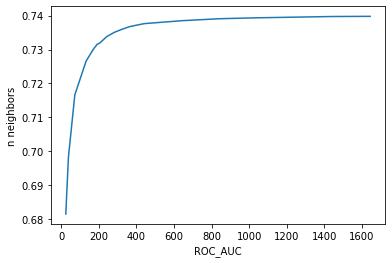

In [10]:
plt.plot(knn_rocauc_n[:,0], knn_rocauc_n[:,1])
plt.xlabel('ROC_AUC')
plt.ylabel('n neighbors')

In [11]:
np.logspace(-4, -2, 32)

array([0.0001    , 0.00011602, 0.0001346 , 0.00015615, 0.00018116,
       0.00021017, 0.00024384, 0.00028289, 0.00032819, 0.00038075,
       0.00044173, 0.00051248, 0.00059456, 0.00068978, 0.00080025,
       0.00092841, 0.00107711, 0.00124961, 0.00144974, 0.00168192,
       0.00195129, 0.0022638 , 0.00262636, 0.00304699, 0.00353498,
       0.00410113, 0.00475794, 0.00551995, 0.006404  , 0.00742964,
       0.00861954, 0.01      ])

In [13]:
np.linspace(1e-4, 1e-2, 32)

array([0.0001    , 0.00041935, 0.00073871, 0.00105806, 0.00137742,
       0.00169677, 0.00201613, 0.00233548, 0.00265484, 0.00297419,
       0.00329355, 0.0036129 , 0.00393226, 0.00425161, 0.00457097,
       0.00489032, 0.00520968, 0.00552903, 0.00584839, 0.00616774,
       0.0064871 , 0.00680645, 0.00712581, 0.00744516, 0.00776452,
       0.00808387, 0.00840323, 0.00872258, 0.00904194, 0.00936129,
       0.00968065, 0.01      ])